<a href="https://colab.research.google.com/github/Shemka/xente-fraud/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google Colab only

In [1]:
!unzip xente.zip

Archive:  xente.zip
  inflating: training.csv            
  inflating: Xente_Variable_Definitions.csv  
  inflating: sample_submission.csv   
  inflating: test.csv                


### Libraries

In [46]:
!pip install vecstack catboost
!pip install requests tabulate "colorama>=0.3.8" future h2o

     |████████████████████████████████| 122.4MB 1.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/fe/31/5a/d0a96f4ab19a49d5381707eb3017b1a41ec89acbeff54a532c
Successfully built h2o


In [47]:
import pandas as pd
import numpy as np
import os
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import *
from sklearn.metrics import f1_score, make_scorer, r2_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from vecstack import stacking

import h2o
from h2o.automl import H2OAutoML
h2o.init()

import warnings
warnings.filterwarnings("ignore")

print('Files in current folder:', *os.listdir())

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpabu1xl5d
  JVM stdout: /tmp/tmpabu1xl5d/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpabu1xl5d/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_unknownUser_v2wnj2
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


Files in current folder: .config submission_6stack_xgboost300_depth3.csv training.csv sample_submission.csv xente.zip submission_7stack_xgboost300_depth3_lambda11.csv Xente_Variable_Definitions.csv test.csv catboost_info sample_data


### Settings

In [6]:
import seaborn as sns
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.option_context('mode.use_inf_as_null', True)

### Helpful functions

In [0]:
def rnd(x):
    if x > 0:
        return 1
    else:
        return 0

def graphics_printing(train, only=False):
    if not only:
        for i in train.columns[(train.columns != 'AccountId') & (train.columns != 'target')]:
            facet = sns.FacetGrid(train, hue='target', aspect=4, height=4)
            facet.map(sns.kdeplot, i, shade=True)
            facet.add_legend()
            plt.show()
    else:
        facet = sns.FacetGrid(train, hue='target', aspect=4, height=4)
        facet.map(sns.kdeplot, only, shade=True)
        facet.add_legend()
        plt.show()

def submit(estimator, test, name='submission'):
    predictions = estimator.predict(test)
    submission = pd.read_csv('sample_submission.csv')
    submission['FraudResult'] = predictions
    submission.to_csv(name+'.csv', index=False)

class WrapperClassifier:
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, Y):
        self.model.fit(X, Y)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)[:,1].reshape(-1)

## EDA *( aka exploratory data analysis)*

### Feature description

In [8]:
pd.read_csv('Xente_Variable_Definitions.csv')

,Column Name,Definition
0,TransactionId,Unique �transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transactions for processing
2,AccountId,Unique number identifying the customer on platform
3,SubscriptionId,Unique number identifying the customer subscription
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item �bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader product categories.


### Feature engineering

In [9]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')

train_shape = train.shape[0]
Y = train.FraudResult
merged_df = pd.concat((train.drop(columns=['FraudResult']), test))
test.shape
merged_df.head(5)

(45019, 15)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2


In [10]:
categories = pd.get_dummies(merged_df['ProductCategory'])
merged_df.drop(columns=['CurrencyCode', 'CountryCode', 'ProductCategory'], inplace=True)
merged_df = pd.concat((merged_df, categories), axis=1)

channels = pd.get_dummies(merged_df.ChannelId)
merged_df = pd.concat([merged_df.drop(columns=['ProductId', 'ProviderId', 'ChannelId', 'TransactionStartTime', 'BatchId', 'SubscriptionId', 'CustomerId', 'TransactionId', 'AccountId']), channels], axis=1)
merged_df = merged_df.fillna(0)
merged_df.head(5)

,Amount,Value,PricingStrategy,airtime,data_bundles,financial_services,movies,other,retail,ticket,transport,tv,utility_bill,ChannelId_1,ChannelId_2,ChannelId_3,ChannelId_4,ChannelId_5
0,1000.0,1000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-20.0,20,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,500.0,500,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,20000.0,21800,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,-644.0,644,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [11]:
merged_df['is_debet'] = (merged_df.Amount/merged_df.Value).transform(rnd)
merged_df['Value_log'] = (merged_df['Value'] + 1).transform(np.log)
# merged_df['Amount_log'] = (merged_df['Amount'] + 1).transform(np.log).fillna(0)
# merged_df['Amount_negative_log'] = (merged_df['Amount'] - merged_df['Amount'].min()).transform(np.log)
#merged_df.drop(columns=['Amount'], inplace=True)

train, test = merged_df[:train_shape], merged_df[train_shape:]
train['target'] = Y
del merged_df; gc.collect()

0

In [12]:
test.shape

(45019, 20)

Train shape: 95662


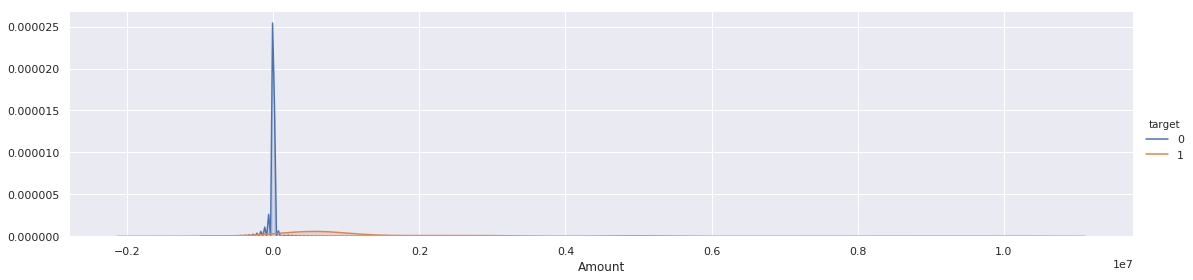

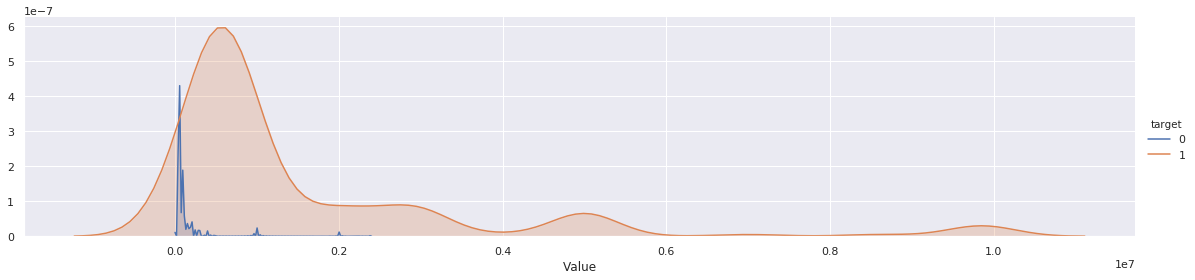

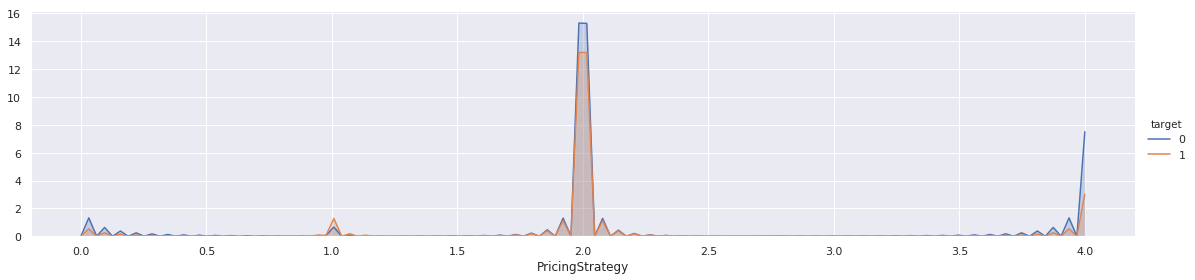

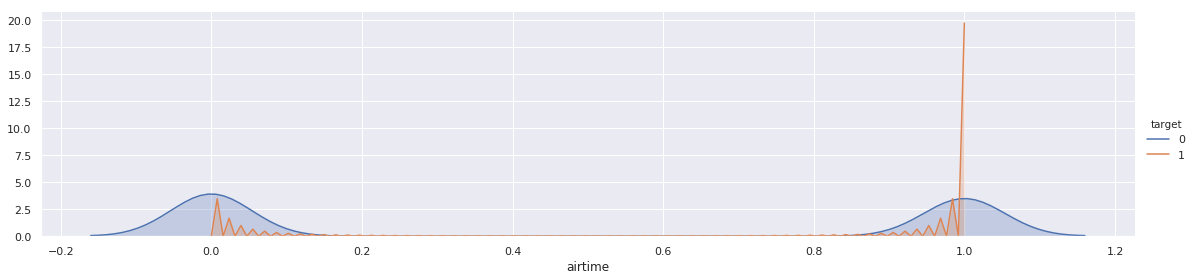

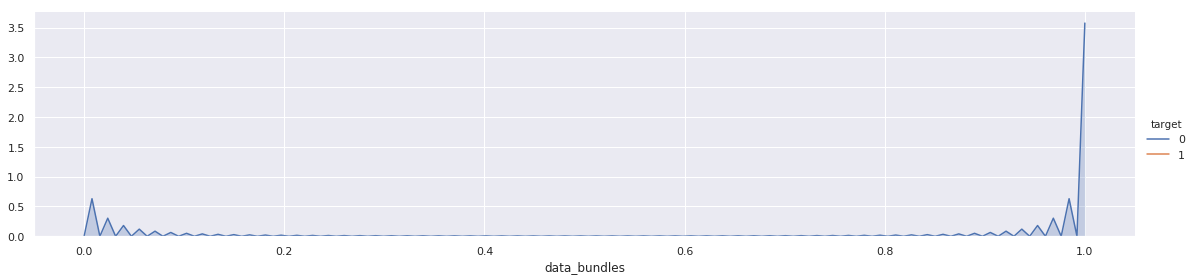

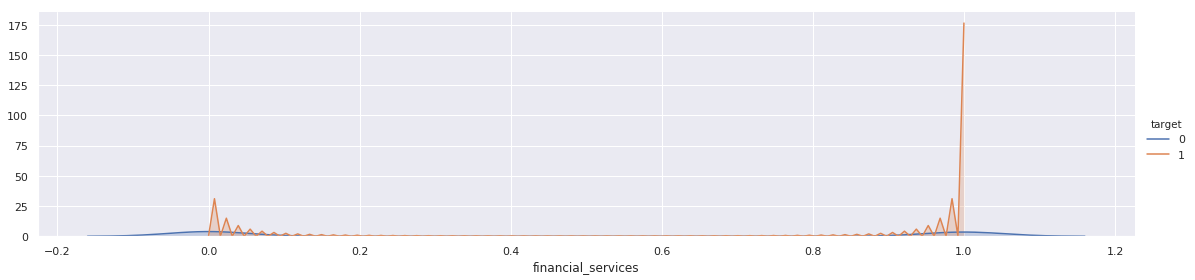

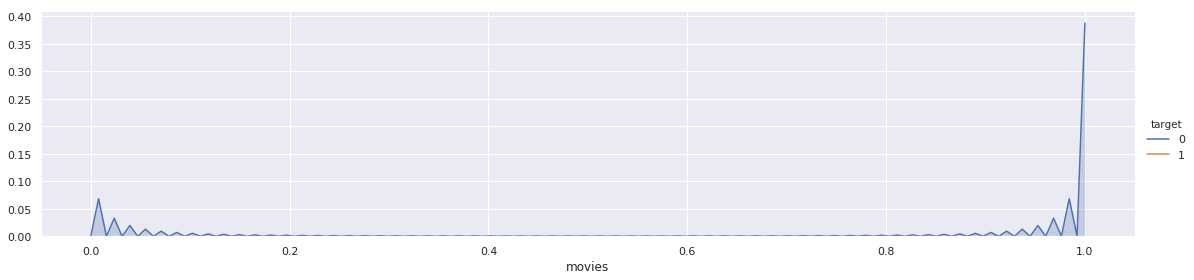

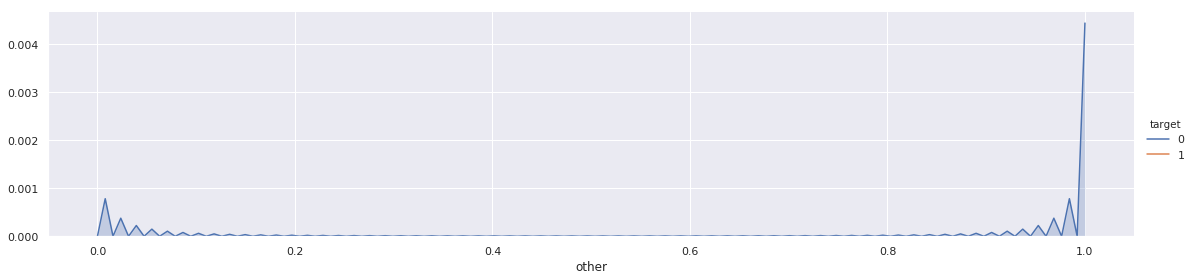

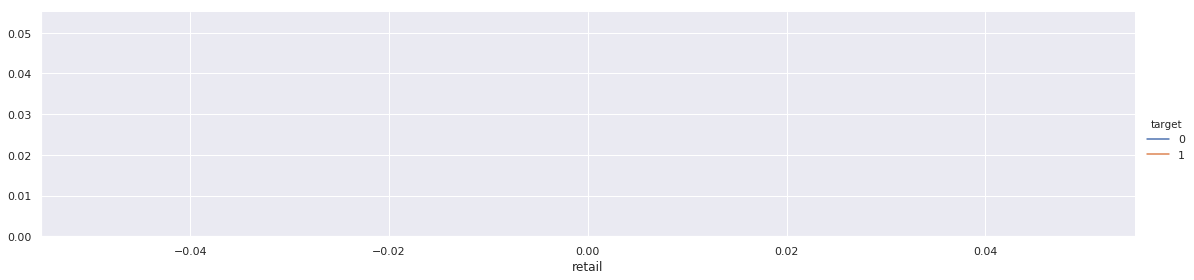

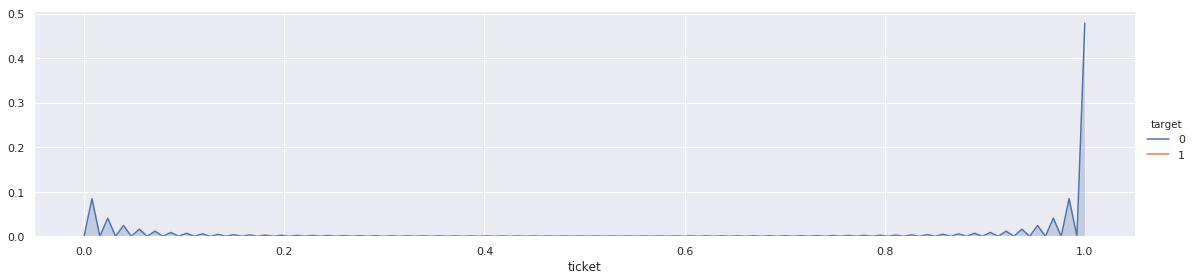

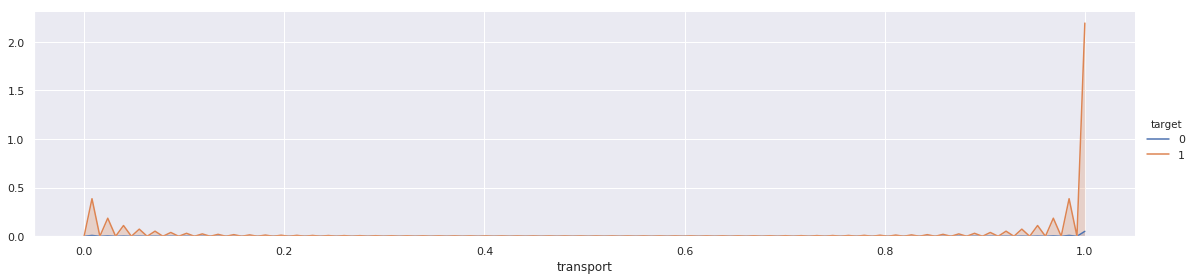

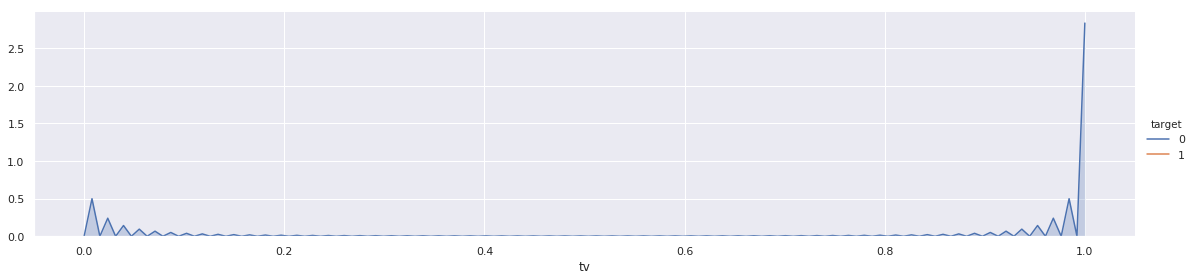

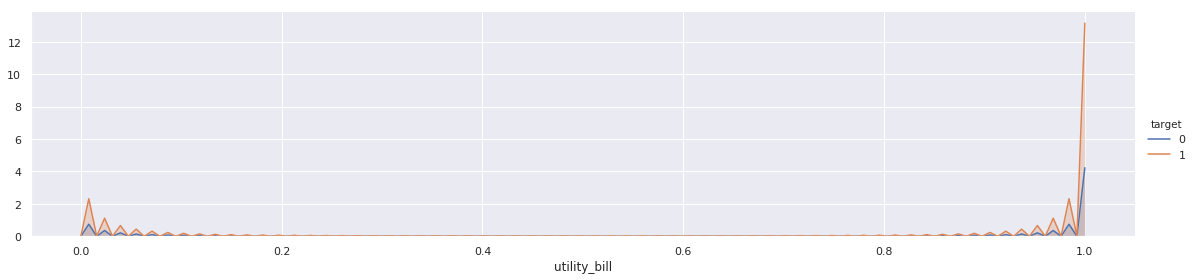

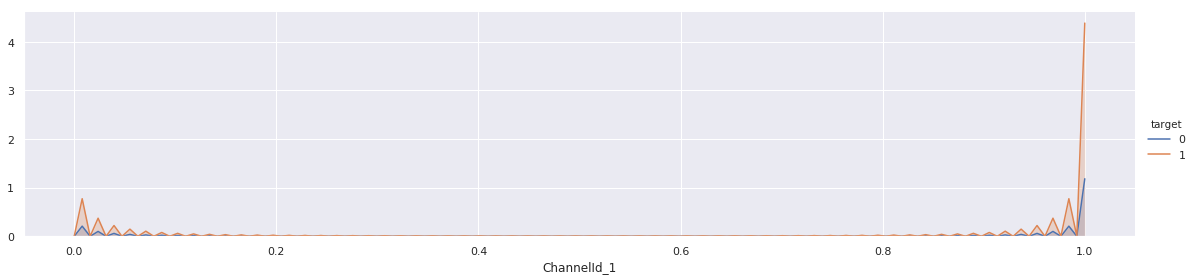

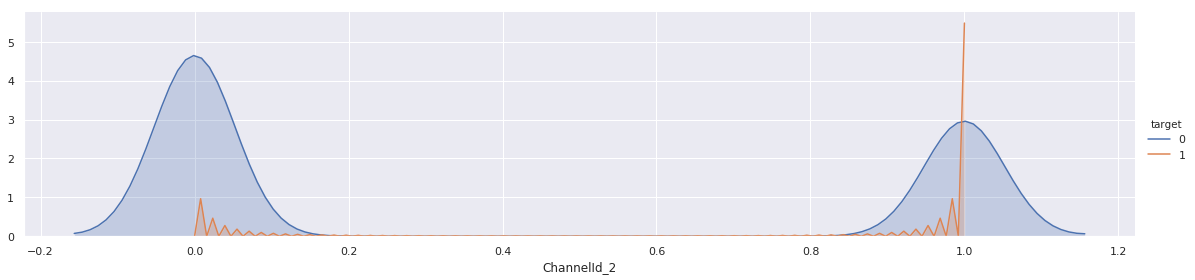

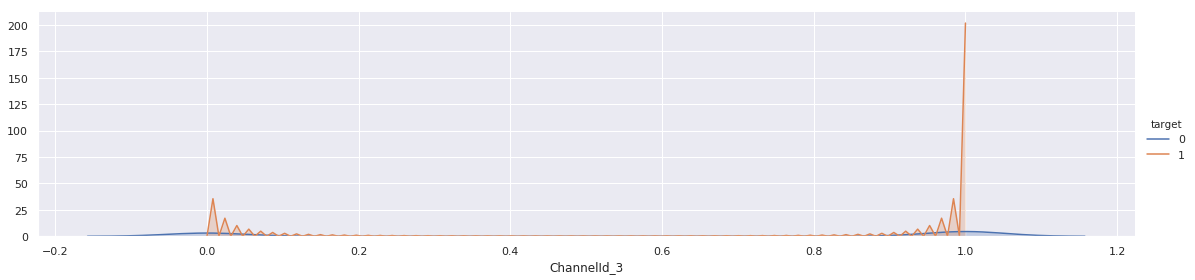

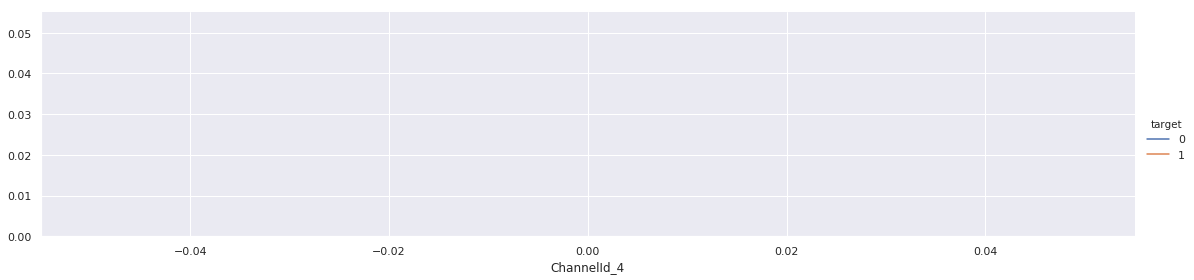

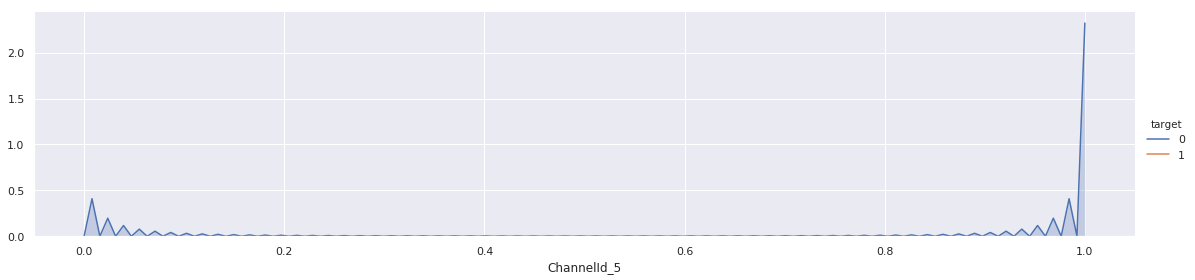

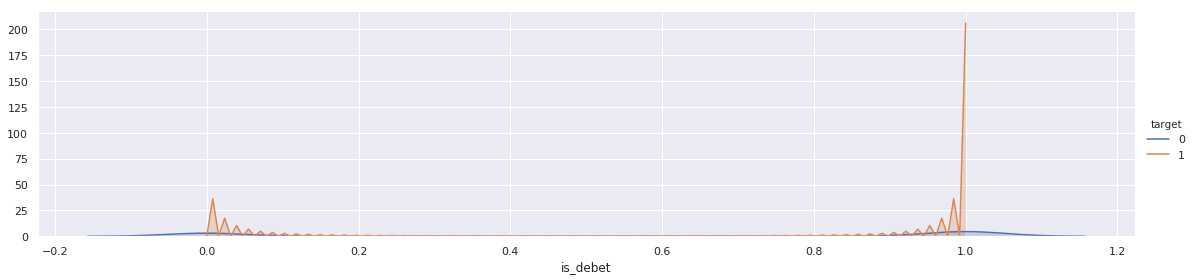

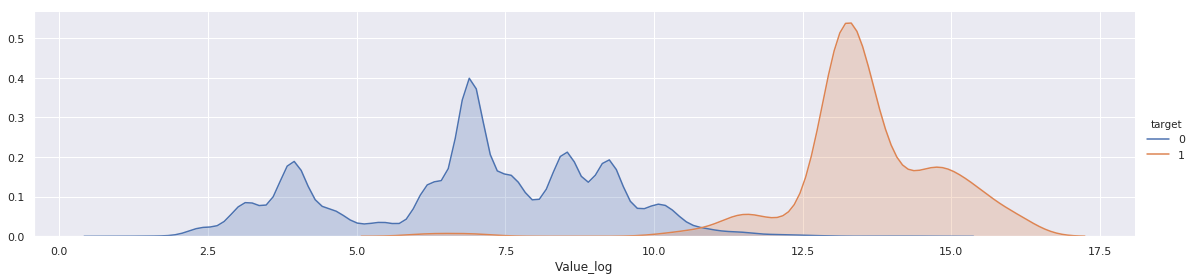

In [13]:
print('Train shape:', train.shape[0])
graphics_printing(train)

Base on **EDA** we can say that some features not informative for prediction of *Fraud Transactions*. Therefore,  we can remove *not informative features* from our dataset. Less informative features in our case are: *ChannelId_4, ChannelId_5, retail, other, ticket, movies, data_bundles, tv*

In [0]:
not_fraud = train[train.target==0]
fraud = train[train.target==1]

train = pd.concat([not_fraud, fraud])
train = train.sample(frac=1).reset_index(drop=True)
Y = train.target.values

In [14]:
train.drop(columns=['target'], inplace=True)
print('Train features count:', train.shape[1])
print('Test features count:', test.shape[1])

Train features count: 20
Test features count: 20


In [15]:
train.shape

(95662, 20)

In [16]:
test.isna().sum()
print('\n')
train.isna().sum()

Amount                0
Value                 0
PricingStrategy       0
airtime               0
data_bundles          0
financial_services    0
movies                0
other                 0
retail                0
ticket                0
transport             0
tv                    0
utility_bill          0
ChannelId_1           0
ChannelId_2           0
ChannelId_3           0
ChannelId_4           0
ChannelId_5           0
is_debet              0
Value_log             0
dtype: int64

Amount                0
Value                 0
PricingStrategy       0
airtime               0
data_bundles          0
financial_services    0
movies                0
other                 0
retail                0
ticket                0
transport             0
tv                    0
utility_bill          0
ChannelId_1           0
ChannelId_2           0
ChannelId_3           0
ChannelId_4           0
ChannelId_5           0
is_debet              0
Value_log             0
dtype: int64

# Model training

In [51]:
models = [
    KNeighborsClassifier(n_neighbors=5,
                        n_jobs=-1),
    
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=300, max_depth=1),
    
    CatBoostClassifier(random_state=0, learning_rate=0.1, 
                  n_estimators=100, max_depth=3, verbose=0),
    
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=300, max_depth=6),
    
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=300, max_depth=3),
    
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=1),
    
    CatBoostClassifier(random_state=0, learning_rate=0.1, 
                  n_estimators=100, max_depth=3, verbose=0)
]

S_train, S_test = stacking(models,                   
                           train.values, Y, test.values,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=True,
         
                           save_dir=None, 
            
                           #metric=roc_auc_score, 
    
                           n_folds=5, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred_bag]
n_models:     [7]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.00474330]
    fold  1:  [0.00777110]
    fold  2:  [0.00628700]
    fold  3:  [0.00965972]
    fold  4:  [0.01860886]
    ----
    MEAN:     [0.00941400] + [0.00487645]
    FULL:     [0.00941380]

model  1:     [RandomForestClassifier]
    fold  0:  [0.00467774]
    fold  1:  [0.00466103]
    fold  2:  [0.00411485]
    fold  3:  [0.00485813]
    fold  4:  [0.00516436]
    ----
    MEAN:     [0.00469522] + [0.00034203]
    FULL:     [0.00469521]

model  2:     [CatBoostClassifier]
    fold  0:  [0.00182032]
    fold  1:  [0.00140457]
    fold  2:  [0.00139691]
    fold  3:  [0.00257571]
    fold  4:  [0.00232883]
    ----
    MEAN:     [0.00190527] + [0.00047859]
    FULL:     [0.00190525]

model  3:     [XGBClassifier]
    fold  0:  [0.00159156]
    fold  1:  [0.00144368]
    fold  2:  [0.00105338]
    fold  3:  

In [52]:
model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=300, max_depth=3)
model.fit(S_train, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
submit(model, S_test, name='submission_7stack_logistic')

## H2O AutoML

In [62]:
train['target'] = Y
train_hf = h2o.H2OFrame(train)
test_hf = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
train_hf['target'] = train_hf['target'].asfactor()

In [65]:
train_hf.head()

Amount,Value,PricingStrategy,airtime,data_bundles,financial_services,movies,other,retail,ticket,transport,tv,utility_bill,ChannelId_1,ChannelId_2,ChannelId_3,ChannelId_4,ChannelId_5,is_debet,Value_log,target
1000,1000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,6.90875,0
-20,20,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3.04452,0
500,500,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,6.21661,0
20000,21800,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,9.98971,0
-644,644,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,6.46925,0
2000,2000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,7.6014,0
10000,10000,4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,9.21044,0
-500,500,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,6.21661,0
500,500,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,6.21661,0
600,600,2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,6.39859,0


In [0]:
y = 'target'
x = train_hf.columns
x.remove(y)

In [79]:
aml = H2OAutoML(max_models = 100, max_runtime_secs=500, seed = 1)
aml.train(x=x, y=y, training_frame=train_hf)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [80]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_2_AutoML_20190711_072156,0.992896,0.0022538,0.0700582,0.0223058,0.000497547
XGBoost_1_AutoML_20190711_072156,0.989929,0.00197139,0.0700425,0.0205576,0.000422616
XGBoost_3_AutoML_20190711_072156,0.984973,0.00864534,0.0726279,0.021256,0.000451818
StackedEnsemble_AllModels_AutoML_20190711_072156,0.982283,0.00265069,0.0752029,0.0199986,0.000399942
StackedEnsemble_BestOfFamily_AutoML_20190711_072156,0.978346,0.00279346,0.067478,0.021297,0.000453562
